# Pemisahan katalog berdasarkan sumber gempa

Jalankan file ini di Openquake yang sudah diinstal di komputer masing-masing.

atau:

Jalankan file ini di jupyter dengan cara mengubah kernel ke `openquake`. Jika kernel `openquake` belum ada, lakukan langkah-langkah berikut ini:

Openquake dapat diunduh di sini:
https://downloads.openquake.org/pkgs/windows/oq-engine/OpenQuake_Engine_3.11.5-1.exe

Install beberapa tambahan packages di openquake:

(Asumsi lokasi instalasi openquake di sini: `C:\Program Files\Openquake Engine\python3.6\`, 
jika tidak maka ubah lokasi tersebut sesuai dengan komputer masing-masing)

1. Buka Command Prompt
2. Install `utm`: `"C:\Program Files\Openquake Engine\python3.6\python.exe" -m pip install utm`
3. Install `jupyter`: `"C:\Program Files\Openquake Engine\python3.6\python.exe" -m pip install jupyter`
4. Daftarkan ke dalam kernel (opsional): `python -m ipykernel install --name "openquake" --display-name "openquake"`


Untuk uji coba, jalankan salah satu baris di bawah ini:

`"C:\Program Files\Openquake Engine\python3.6\Scripts\jupyter.exe" notebook`

atau

`"C:\Program Files\Openquake Engine\python3.6\Scripts\jupyter-notebook.exe"`

## 1. Import packages

Hal ini memastikan apakah python yang digunakan sudah menyediakan packages yang dibutuhkan.

In [1]:
from custom_openquake import *

# folder penyimpanan
dir_figs = os.path.join(os.getcwd(), 'figs')
os.makedirs(dir_figs, exist_ok=True)

## 3. Katalog gempa (declustered)

In [2]:
# membuka data pkl
catalogue_declustered = open_pkl('tmp_OQ002_catalogue_declustered.pkl')

## 4. Patahan

/Users/yudhastyawan/openquake/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/yudhastyawan/openquake/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/yudhastyawan/openquake/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initial

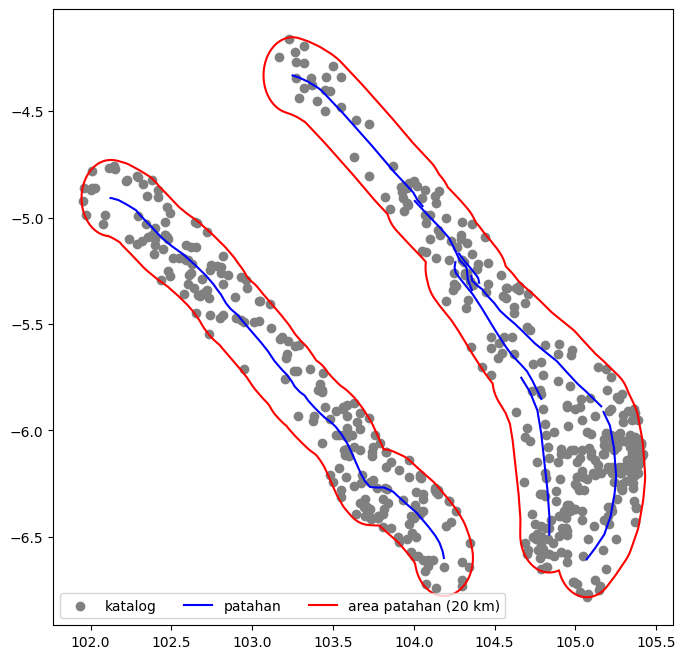

In [3]:
# membuka data pkl
fault_geoms = open_pkl('tmp_OQ003_fault_geoms.pkl')

# membuat area dari patahan
area_faults, area_faults_coords = create_area_faults(fault_geoms, distance=20)

# memisahkan katalog berdasarkan area patahan
catalogue_area_faults = create_catalogue_from_area_faults(catalogue_declustered, area_faults, depth=20)

## >> Future Warning dapat diabaikan <<


list_variables = (
    catalogue_area_faults,
    fault_geoms,
    area_faults
)
list_colors = (
    ['grey','none'],
    ['b','none'],
    ['r','none']
)
list_labels = (
    "katalog",
    "patahan",
    "area patahan (20 km)"
)
fig, _ = quick_create_maps(list_variables, list_colors, list_labels, figsize=(8,8))


In [23]:
# area patahan sumatera
catalogue_to_pkl(catalogue_area_faults['merged'][0], "dict_catalogue_area_sumatera_fault.pkl")

# area patahan mentawai
catalogue_to_pkl(catalogue_area_faults['individual'][0], "dict_catalogue_area_mentawai_fault.pkl")

# simpan variabel untuk dipakai di tahapan berikutnya
variable_to_pkl(catalogue_area_faults, "tmp_OQ004_catalogue_area_faults.pkl")
variable_to_pkl(area_faults_coords, "tmp_OQ004_area_faults_coords.pkl")

## 5. Megathrust

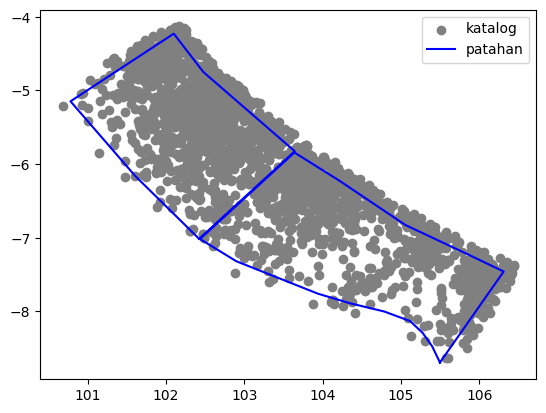

In [91]:
megathrust_geoms = open_pkl("tmp_OQ003_megathrust_geoms.pkl")

catalogue_megathrusts = create_catalogue_megathrusts(catalogue_declustered, megathrust_geoms, distance = 20)

# katalog 1
catalogue_to_pkl(catalogue_megathrusts[0], "dict_catalogue_megathrust_1.pkl")

# katalog 2
catalogue_to_pkl(catalogue_megathrusts[1], "dict_catalogue_megathrust_2.pkl")

# simpan variabel untuk dipakai di tahapan berikutnya
variable_to_pkl(catalogue_megathrusts, "tmp_OQ004_catalogue_megathrusts.pkl")

fig, ax = plt.subplots()
quick_map(catalogue_megathrusts, ['grey','none'], "katalog", ax=ax)
quick_map(megathrust_geoms, ['b','none'], "patahan", ax=ax)
ax.legend()

## 6. Shallow Background

In [7]:
shallow_background_geoms = open_pkl("tmp_OQ003_shallow_background_geoms.pkl")

catalogue_shallow_backgrounds = create_catalogue_from_shallow_backgrounds(
    catalogue_declustered, shallow_background_geoms, lower_depth=20
)

for i in range(len(catalogue_shallow_backgrounds)):
    catalogue_to_pkl(catalogue_shallow_backgrounds[i], f"dict_catalogue_shallow_backgrounds_{i+1}.pkl")

# simpan variabel untuk dipakai di tahapan berikutnya
variable_to_pkl(catalogue_shallow_backgrounds, "tmp_OQ004_catalogue_shallow_backgrounds.pkl")

## 7. Deep Background (intraslab)

In [8]:
deep_background_geoms = open_pkl("tmp_OQ003_deep_background_geoms.pkl")

def create_catalogue_from_deep_backgrounds(catalogue, deep_background_geoms, 
                                           upper_depth=50, increment=100, lower_depth=350):
    range_list = list(range(upper_depth, lower_depth, increment)) + [lower_depth]
    
    poly_background = [
        PolyOQ([PointOQ(lon, lat) for lon, lat in zip(*geom)]) for geom in deep_background_geoms
    ]
    
    catalogue_backgrounds = [
        [
            copy_cutPoly_cutDepth(catalogue, poly, 
                                  lower_depth = range_list[i+1], upper_depth = range_list[i]
                                 ) for i in range(len(range_list)-1)
        ] for poly in poly_background
    ]
    return catalogue_backgrounds, range_list

catalogue_deep_backgrounds, range_list = create_catalogue_from_deep_backgrounds(
    catalogue_declustered, deep_background_geoms, upper_depth=50, increment=100, lower_depth=350
)

for i in range(len(catalogue_deep_backgrounds)):
    for j in range(len(range_list)-1):
        catalogue_to_pkl(
            catalogue_deep_backgrounds[i][j], 
            f"dict_catalogue_deep_backgrounds_{i+1}_{range_list[j]}-{range_list[j+1]}.pkl"
        )

# simpan variabel untuk dipakai di tahapan berikutnya
variable_to_pkl((catalogue_deep_backgrounds, range_list), "tmp_OQ004_catalogue_deep_backgrounds.pkl")